In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## Importing the Required Libraries

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Versions of Tensorflow and Tensorflow Decision Forests
print(f'Tensorflow Version: {tf.__version__}')
print(f'TfDf Version: {tfdf.__version__}')

Tensorflow Version: 2.11.0
TfDf Version: 1.2.0


## Loading the data

In [4]:
# Loading the Dataset
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

# Sample:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
# Shape of the training Data:
df.shape

(8693, 14)

## Gathering information about the data

In [6]:
# EDA:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


True     4378
False    4315
Name: Transported, dtype: int64


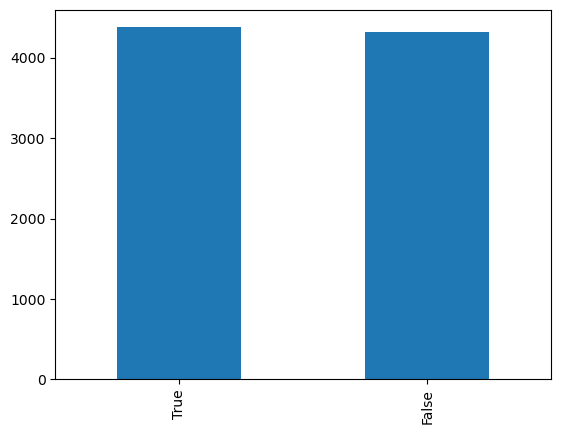

In [8]:
# Bar Plot for the Survived:
count = df['Transported'].value_counts()
count.plot(kind = 'bar')
print(count)

## Numerical Feature Distributions:

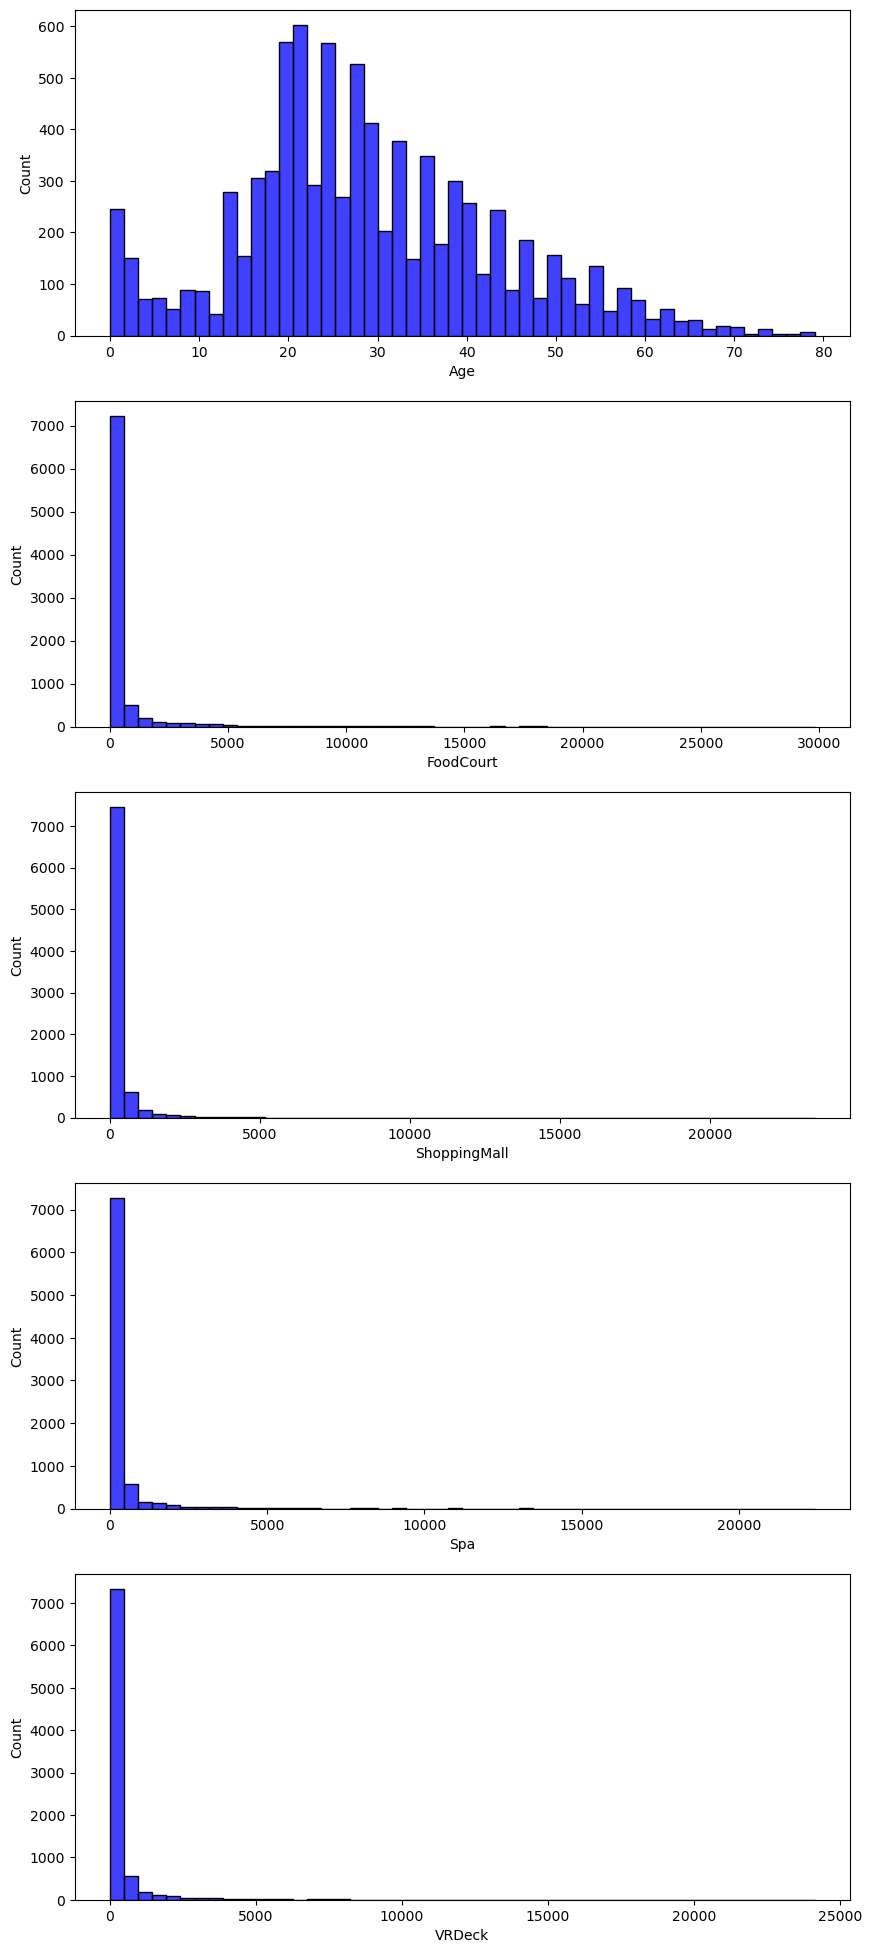

In [9]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(df['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(df['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(df['VRDeck'], color='b', bins=50, ax=ax[4]);
plt.show()

## Preparing the Dataset

In [10]:
# Drop unnecessary Columns
# We drop PassengerId and Name as the do not affect the Target Variable
df = df.drop(['PassengerId', 'Name'], axis=1)

# Sample:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [11]:
# Missing Value informtion:
df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [12]:
# Let us fill the Values using 0
# TfDf will handle missing values in Categorical Columns
df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
df.isnull().sum().sort_values(ascending=False)

HomePlanet      201
Cabin           199
Destination     182
RoomService     181
Age             179
CryoSleep         0
VIP               0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [13]:
# TfDf cannot handle Boolean Values and our Target Variable is in boolean form
# Let us transform that into binary values (0's and 1's)
label = "Transported"
df[label] = df[label].astype(int)

In [14]:
# Let us transform CryoSleep and VIP into binary variables
df['VIP'] = df['VIP'].astype(int)
df['CryoSleep'] = df['CryoSleep'].astype(int)

In [15]:
df.sample(1)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
2914,Mars,1,F/654/P,55 Cancri e,25.0,0,0.0,0.0,0.0,0.0,0.0,1


As we can see that the Cabin column has three categories. Let us split them so that we can get more accurate predictions.

In [16]:
df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)

In [17]:
df.sample(1)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
5892,Mars,0,F/1199/S,TRAPPIST-1e,28.0,0,NaN,0.0,129.0,0.0,0.0,0,F,1199,S


In [18]:
# Let us drop the original column 'Cabin' from the dataset
df = df.drop('Cabin', axis=1) #Drops the entire column

In [19]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S


Since the categorical data can be managed by Tensorflow Decision Forests, there is no need to preprocess them. We can proceed to split the dataset into train and test set.

In [20]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

7017 examples in training, 1676 examples in testing.


In [21]:
# Let us convert the pandas dataframe to tensorflow dataset format.

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

In [22]:
# List of all models
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [23]:
# We use Random Forest Model
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")


Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmp08pfysqp as temporary training directory


In [24]:
# Let us define or model
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"]) 

Use /tmp/tmpt4ou60p6 as temporary training directory


In [25]:
# Model Training
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:06.426712. Found 7017 examples.
Training model...


[INFO 2023-04-06T19:32:17.904693021+00:00 kernel.cc:1214] Loading model from path /tmp/tmpt4ou60p6/model/ with prefix cc486c5b6f0b481f


Model trained in 0:00:56.516032
Compiling model...


[INFO 2023-04-06T19:32:19.094494152+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 238042 node(s), and 13 input feature(s).
[INFO 2023-04-06T19:32:19.094548023+00:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-04-06T19:32:19.094593649+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [26]:
# Let us visualize the model
# This is the visualization of a tree. By default tensorflow uses 300 trees
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=110, max_depth=3)

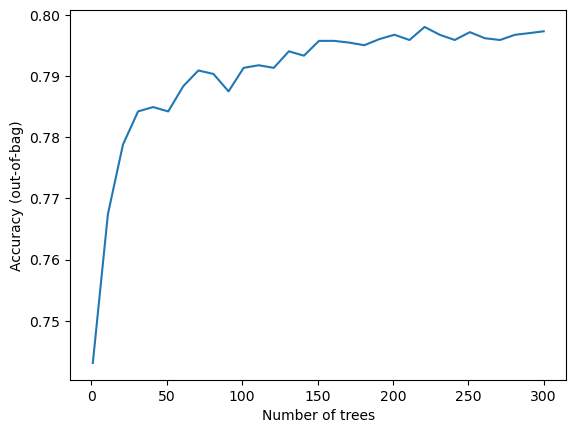

In [27]:
# Le us evaluate the model on the OOB set
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

In [28]:
# General Stats about the OOB
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=7017, accuracy=0.7973492945703292, loss=0.5570347068750496, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [29]:
# Let us validate the model using the validation Dataset
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 1s 63ms/step - loss: 0.0000e+00 - accuracy: 0.7965
loss: 0.0000
accuracy: 0.7965


In [30]:
# Variable Importance
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH


In [31]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["SUM_SCORE"]

[("Cabin_num" (4; #1), 261339.4802761887),
 ("CryoSleep" (1; #2), 140121.43369153969),
 ("Spa" (1; #10), 115744.86332404416),
 ("RoomService" (1; #7), 98098.06218612776),
 ("VRDeck" (1; #12), 96436.61740918976),
 ("Deck" (4; #3), 86407.69858785218),
 ("Age" (1; #0), 83554.34713326611),
 ("FoodCourt" (1; #5), 78115.81994676322),
 ("ShoppingMall" (1; #8), 54224.68235315458),
 ("HomePlanet" (4; #6), 51871.31088760303),
 ("Side" (4; #9), 18177.866253579967),
 ("Destination" (4; #4), 17552.280663679703),
 ("VIP" (1; #11), 260.78685989952646)]

## Submission

In [32]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df.PassengerId

# Replace NaN values with zero
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df = test_df.drop('Cabin', axis=1)

# Convert boolean to 1's and 0's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# Convert pd dataframe to tf dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get the predictions for testdata
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()


5/5 [==============================] - 1s 67ms/step


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [33]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
